# FlowNet tracking

### Run inference with pretrained model

In [ ]:
!python3 run_inference.py sequences-train/ flownets_EPE1.951.pth --sequence bear

=> will save raw output and RGB visualization
=> fetching img pairs in 'images/'
=> will save everything to images/flow
Making image pairs
image pairs !!!  [[Path('images/bear-001.bmp'), Path('images/bear-002.bmp')], [Path('images/bear-002.bmp'), Path('images/bear-003.bmp')], [Path('images/bear-003.bmp'), Path('images/bear-004.bmp')], [Path('images/bear-004.bmp'), Path('images/bear-005.bmp')], [Path('images/bear-005.bmp'), Path('images/bear-006.bmp')], [Path('images/bear-006.bmp'), Path('images/bear-007.bmp')], [Path('images/bear-007.bmp'), Path('images/bear-008.bmp')], [Path('images/bear-008.bmp'), Path('images/bear-009.bmp')], [Path('images/bear-009.bmp'), Path('images/bear-010.bmp')], [Path('images/bear-010.bmp'), Path('images/bear-011.bmp')], [Path('images/bear-011.bmp'), Path('images/bear-012.bmp')], [Path('images/bear-012.bmp'), Path('images/bear-013.bmp')], [Path('images/bear-013.bmp'), Path('images/bear-014.bmp')], [Path('images/bear-014.bmp'), Path('images/bear-015.bmp')], [Pa

In [1]:
from pathlib import Path
from imageio import imread, imwrite
import numpy as np
from glob import glob
import time
# from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator

import os
import cv2
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import distutils.dir_util
from skimage.measure import regionprops

/tmp/ipykernel_128557/2089900778.py:15: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.dir_util


### Tracking

In [ ]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100



def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.


def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap


def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))


def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

def concatenation(unary_flow, to_ref_flow):
    flow = np.zeros((unary_flow.shape[0], unary_flow.shape[1], 2), dtype=float)

    x0 = np.arange(0, unary_flow.shape[0])
    y0 = np.arange(0, unary_flow.shape[1])

    # create interpolators for both flow components
    fx = RegularGridInterpolator((x0, y0), to_ref_flow[:, :, 1], method='cubic', bounds_error=False, fill_value=None)
    fy = RegularGridInterpolator((x0, y0), to_ref_flow[:, :, 0], method='cubic', bounds_error=False, fill_value=None)

    for x in range(unary_flow.shape[0]):
        for y in range(unary_flow.shape[1]):
            # compute new coordinates based on unary flow
            coords = np.array([x + unary_flow[x, y, 1], y + unary_flow[x, y, 0]])

            # interpolate and update the flow
            flow_x = fx(coords)
            flow_y = fy(coords)
            flow[x, y, 1] = unary_flow[x, y, 1] + flow_x.item()
            flow[x, y, 0] = unary_flow[x, y, 0] + flow_y.item()


    return flow

In [ ]:
def tracking(img_path, flow_path, name):
    print("Tracking of sequence: ", name)
    
    # preprocess = '_detail_enhance'

    # flow_files = sorted(glob(os.path.join(flow_path,name + '*.npy')))
    img_ext = 'bmp'
    mask_ext = 'png'
    img_files = sorted(glob(os.path.join(img_path,name + '*.' + img_ext)))
    # mask_files = sorted(glob(os.path.join(img_path,name + '*.' + mask_ext)))

    im_begin = 1
    im_end = len(img_files)
    # print(im_end)

    img_begin = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im_begin))).astype(np.float32)/255.
    mask_begin = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im_begin)))
    seq_dices_FN, seq_fmeasures_FN, centroid_dist_FN = [], [], []
    flow_FN_final = np.zeros((img_begin.shape[0], img_begin.shape[1], 2))
    start = time.time()

    # Plot masks in a row for presentation
    plt.figure(figsize=(25,5))
    subplot_step = 10
    subplot_list = [2,subplot_step,subplot_step*2,subplot_step*3,subplot_step*4]

    first_image = True

    for im in range(im_begin+1,im_end+1):
        # print(im)
        img_current = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im))).astype(np.float32)/255.
        # print(img_current.shape)
        mask_current = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im)))
        # img_precendent = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im-1))).astype(np.float32)/255.

        # flow_FN = np.load(os.path.join(flow_path,name+'-%0*d'%(3,im)+'flow.npy'))
        flow_filename = f"{name}-flow-{im-1:03d}-{im:03d}.npy"
        flow_FN = np.load(os.path.join(flow_path,flow_filename))

        if first_image is True:
            flow_FN_final = flow_FN
            first_image = False
        else:
            flow_FN_final = concatenation(flow_FN, flow_FN_final)

        flow_FN_resized = cv2.resize(flow_FN_final, (img_current.shape[1], img_current.shape[0]), interpolation=cv2.INTER_LINEAR)

        propagation_FN = propagate_mask(flow_FN_resized, img_current, mask_begin) 
        boundaries_FN = mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation_FN, color=(1,0,0))
        seq_dices_FN.append(dice_assessment(mask_current, propagation_FN))
        seq_fmeasures_FN.append(db_eval_boundary(mask_current, propagation_FN))
        # centroid_dist_FN.append(centroid_assessment(mask_current, propagation_FN))

        # Save mask as png image
        binary_mask = (propagation_FN > 0).astype(np.uint8)
        mask_uint8 = binary_mask * 255
        mask_filename = f"mask_{name}_{im:03d}.png"
        mask_filepath = os.path.join('results', mask_filename)
        cv2.imwrite(mask_filepath, mask_uint8)
        # print(f"Saved mask: {mask_filepath}")

        # Plot masks in a row for presentation
        if im in subplot_list:
            plt.subplot(1,5,im//subplot_step+1)
            plt.axis('off')
            plt.title("Frame {}".format(im))
            plt.imshow(boundaries_FN)
    plt.show()

    end = time.time()
    # print("The process took {:.2f} seconds".format(end-start))
    print("The process took {:.2f} minutes".format((end-start)/60))

    # Save results
    np.save("./results/" + name + "-dice.npy", seq_dices_FN)
    np.save("./results/" + name + "-fmeasures.npy", seq_fmeasures_FN)
    np.save("./results/" + name + "-centroid.npy", centroid_dist_FN)
    
    print("*"*50)
    print("Average Dice score:", np.mean(seq_dices_FN))
    print("Average F-measure :", np.mean(seq_fmeasures_FN))
    print("Average Centroid-dist:", np.mean(centroid_dist_FN))
    print("*"*50)



### Tracking of a single sequence

Tracking of sequence:  bear


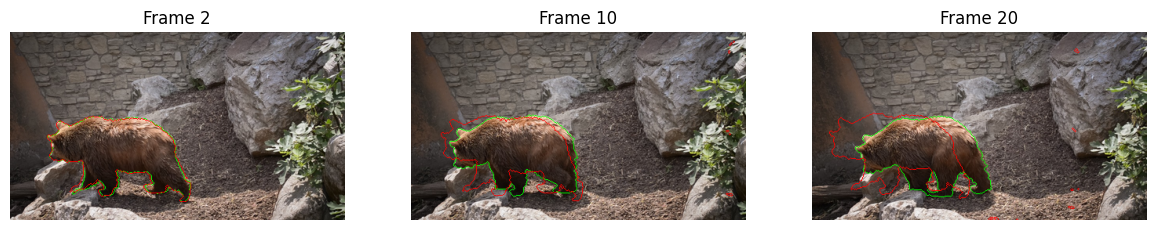

The process took 1.57 minutes
**************************************************
Average Dice score: 75.10122796597896
Average F-measure : 39.439725495070995
Average Centroid-dist: 19.623209374465684
**************************************************


In [ ]:
img_path = 'sequences-train'
flow_path = 'sequences-train/flow'
# flow_path = 'sequences-train/flow_finetuned'
name = 'bear'
tracking(img_path, flow_path, name)

### Tracking of all sequences

Tracking of sequence:  bear


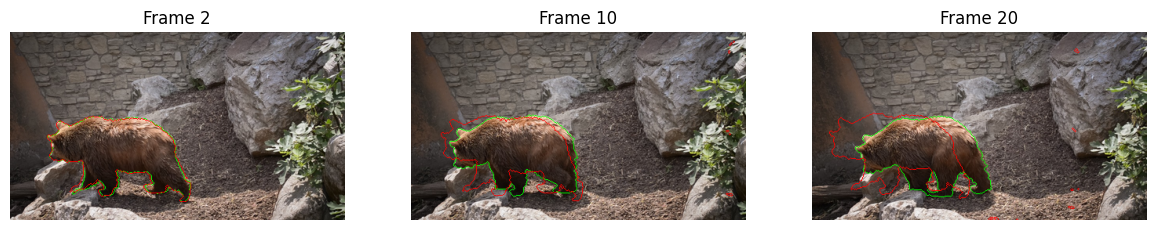

The process took 1.18 minutes
**************************************************
Average Dice score: 75.10122796597896
Average F-measure : 39.439725495070995
Average Centroid-dist: nan
**************************************************
Tracking of sequence:  book


/home/cecilia/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cecilia/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int),

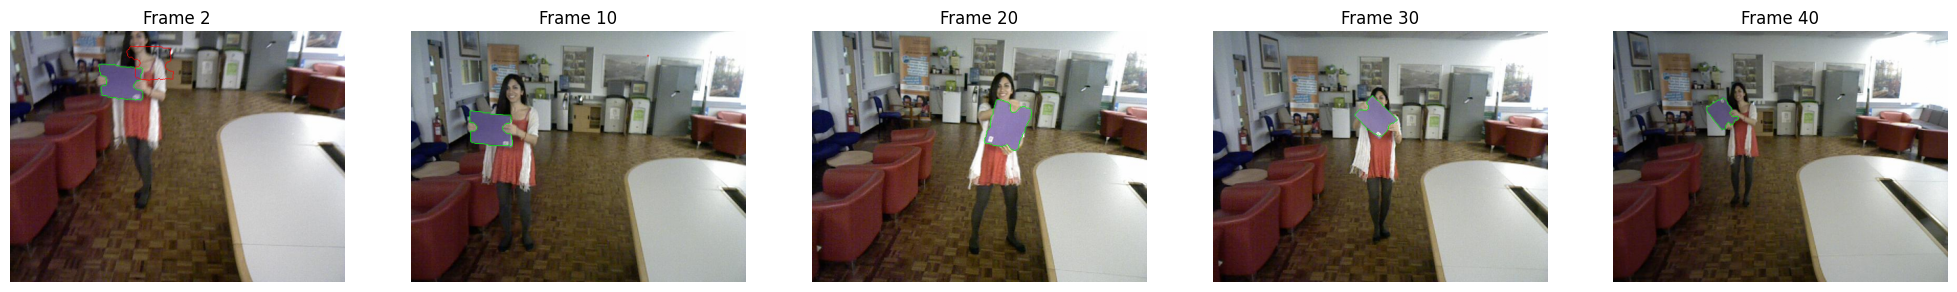

The process took 3.11 minutes
**************************************************
Average Dice score: 0.09452201933404941
Average F-measure : 0.2534691726681891
Average Centroid-dist: nan
**************************************************
Tracking of sequence:  bag


/home/cecilia/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cecilia/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
/tmp/ipykernel_128557/1749910019.py:164: RuntimeWarning: invalid value encountered in cast
  x_, y_ = np.rint(x+flow[x,y,1]).astype(int),

ValueError: RHS must contain only finite numbers

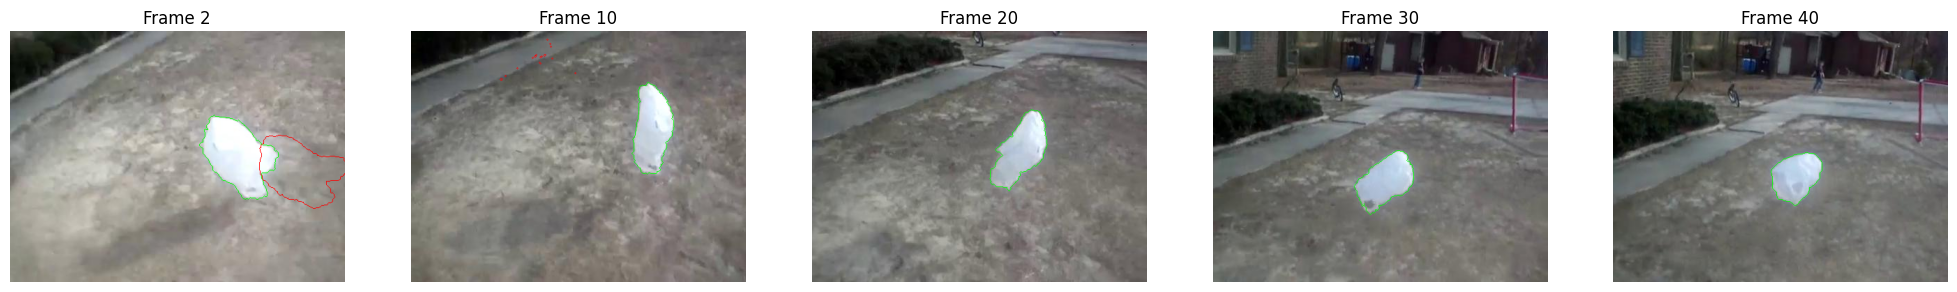

In [67]:
sequence_list = ['bear', 'book', 'bag', 'camel', 'rhino', 'swan']
for sequence in sequence_list:
    tracking('sequences-train', 'sequences-train/flow', sequence)

## Plot results from saved files

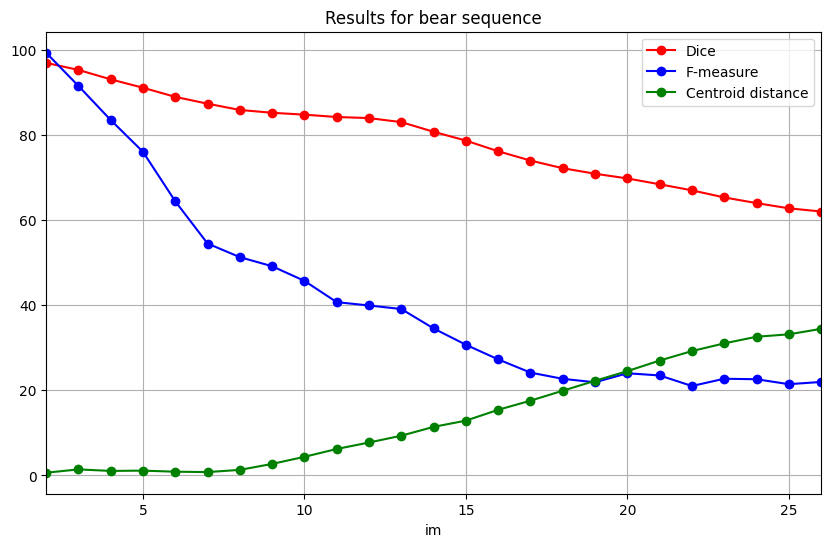

In [51]:
name = 'bear'
results_directory = 'results'
img_path = 'sequences-train'
# flow_path = 'sequences-train/flow'
flow_path = 'sequences-train/flow_finetuned'

flow_files = sorted(glob(os.path.join(flow_path,name + '*.npy')))
img_ext = 'bmp'
img_files = sorted(glob(os.path.join(img_path,name + '*.' + img_ext)))
im_begin = 1
im_end = len(img_files)


# Load results
dice = np.load(f'{results_directory}/{name}-dice.npy')
fmeasure = np.load(f'{results_directory}/{name}-fmeasures.npy')
centroid = np.load(f'{results_directory}/{name}-centroid.npy')


# Plot results
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(10, 6))
plt.plot(x,dice, marker='o', color='r')
plt.plot(x,fmeasure, marker='o', color='b')
plt.plot(x,centroid, marker='o', color='g')
plt.legend(['Dice', 'F-measure', 'Centroid distance'])
plt.xlim((im_begin+1,im_end))
plt.xlabel("im")
plt.grid()
plt.title('Results for {} sequence'.format(name))
plt.show()

